# STOCK PRICE TREND PREDICTION WITH LSTMs ML MODEL.

#### Importing the necessary tools and libraries.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from pandas_datareader import data
import urllib.request, json
import os
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

In [2]:
# Loading the dataset
df=pd.read_csv('C:/Users/peter/Data Science/Stock Price Prediction Model/MSFT.csv')

#### Dataset audition- getting familiar with the dataset.

In [3]:
# first five rows of the dataset
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1986-03-13,0.088542,0.101563,0.088542,0.097222,0.061109,1031788800
1,1986-03-14,0.097222,0.102431,0.097222,0.100694,0.063292,308160000
2,1986-03-17,0.100694,0.103299,0.100694,0.102431,0.064383,133171200
3,1986-03-18,0.102431,0.103299,0.098958,0.099826,0.062746,67766400
4,1986-03-19,0.099826,0.100694,0.097222,0.098090,0.061655,47894400


In [4]:
# Last five rows of the dataset.
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
9166,2022-07-26,259.859985,259.880005,249.570007,251.899994,251.899994,39348000
9167,2022-07-27,261.160004,270.049988,258.850006,268.739990,268.739990,45994000
9168,2022-07-28,269.750000,277.839996,267.869995,276.410004,276.410004,33459300
9169,2022-07-29,277.700012,282.000000,276.630005,280.739990,280.739990,32129400
9170,2022-08-01,277.820007,281.279999,275.839996,278.010010,278.010010,21527300


In [5]:
# Number of columns and rows in the dataset
df.shape

(9171, 7)

In [6]:
# The columns available in the dataset
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [7]:
# Data summary for the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9171 entries, 0 to 9170
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       9171 non-null   object 
 1   Open       9171 non-null   float64
 2   High       9171 non-null   float64
 3   Low        9171 non-null   float64
 4   Close      9171 non-null   float64
 5   Adj Close  9171 non-null   float64
 6   Volume     9171 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 501.7+ KB


#### Descriptive statistics for the dataset.

In [8]:
# Generating statistical analysis  of the dataset.
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,9171.000000,9171.000000,9171.000000,9171.000000,9171.000000,9.171000e+03
mean,43.535704,44.001647,43.055195,43.545169,38.415198,5.848036e+07
std,63.538162,64.180438,62.842807,63.549633,63.841195,3.837422e+07
min,0.088542,0.092014,0.088542,0.090278,0.056745,2.304000e+06
25%,4.496094,4.562500,4.445313,4.511719,2.835863,3.432925e+07
50%,26.900000,27.180000,26.650000,26.910000,18.986191,5.179460e+07
75%,41.099998,41.555000,40.400002,41.025625,29.836731,7.230240e+07
max,344.619995,349.670013,342.200012,343.109985,341.606354,1.031789e+09


#### Data Cleaning -checking for missing values.

In [9]:
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [10]:
# Checking the total number of missing data.
df.isnull().sum().sum()

0

#### Data Analysis Process.

In [11]:
# We only need two columns; Date and Close.
df=df[['Date','Close']]
df

,Date,Close
0,1986-03-13,0.097222
1,1986-03-14,0.100694
2,1986-03-17,0.102431
3,1986-03-18,0.099826
4,1986-03-19,0.098090
...,...,...
9166,2022-07-26,251.899994
9167,2022-07-27,268.739990
9168,2022-07-28,276.410004
9169,2022-07-29,280.739990


In [12]:
# Converting Close from dtype object to datetime
def str_to_datetime(s):
    split= s.split('-')
    year, month, day = int(split[0]), int(split[1]), int(split[2])
    return datetime.datetime(year=year, month=month, day=day)

datetime_object=str_to_datetime('2021-08-05')
datetime_object   

datetime.datetime(2021, 8, 5, 0, 0)

In [13]:
# Applying the datetime function to the entire date column
df['Date']=df['Date'].apply(str_to_datetime)
df['Date']

0      1986-03-13
1      1986-03-14
2      1986-03-17
3      1986-03-18
4      1986-03-19
          ...    
9166   2022-07-26
9167   2022-07-27
9168   2022-07-28
9169   2022-07-29
9170   2022-08-01
Name: Date, Length: 9171, dtype: datetime64[ns]

In [14]:
# Making the Date column be the index column
df.index = df.pop('Date')
df.head()

,Close
Date,
1986-03-13,0.097222
1986-03-14,0.100694
1986-03-17,0.102431
1986-03-18,0.099826
1986-03-19,0.098090


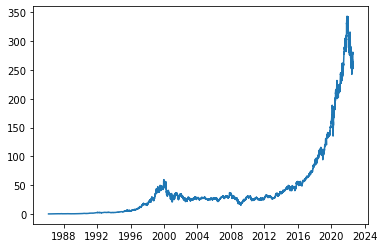

In [15]:
# Checking the graph trend for the data
plt.plot(df.index, df['Close'])

In [16]:
import numpy as np

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date
  
  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)
    
    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
    
    if last_time:
      break
    
    target_date = next_date

    if target_date == last_date:
      last_time = True
    
  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates
  
  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]
  
  ret_df['Target'] = Y

  return ret_df

# Start day second time around: '2021-03-25'
windowed_df = df_to_windowed_df(df, 
                                '2021-08-01', 
                                '2022-08-01', 
                                n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2021-08-01,286.540009,286.220001,286.500000,284.910004
1,2021-08-03,286.500000,284.910004,284.820007,287.119995
2,2021-08-04,284.910004,284.820007,287.119995,286.510010
3,2021-08-05,284.820007,287.119995,286.510010,289.519989
4,2021-08-06,287.119995,286.510010,289.519989,289.459991
...,...,...,...,...,...
247,2022-07-26,264.839996,260.359985,258.829987,251.899994
248,2022-07-27,260.359985,258.829987,251.899994,268.739990
249,2022-07-28,258.829987,251.899994,268.739990,276.410004
250,2022-07-29,251.899994,268.739990,276.410004,280.739990


In [17]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((252,), (252, 3, 1), (252,))

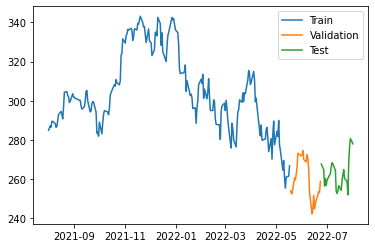

In [18]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [21]:
model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

NotImplementedError: Cannot convert a symbolic Tensor (lstm_2/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported